In [1]:
# Load library
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import h5py
import time
from sklearn import multioutput
import xgboost as xgb

In [2]:
# Seed
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759


In [5]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759/Data')
Data1 = loadmat('p5759_Inputs.mat')
Data2 = loadmat('p5759_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['K','V','AE','Amp','SS','TTF']]
df_SS = df2[['K','V','AE','Amp','SS']]
df_TTF = df2[['K','V','AE','Amp','TTF']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
                 K      V     AE       Amp
0      3511910.82  23.33   1.50  12313.25
1      3511805.49  23.16   1.67  12390.65
2         3807.30  16.44   1.67  12433.71
3          992.68  16.27   1.33  12425.59
4          999.61  16.27   1.33  12417.39
...           ...    ...    ...       ...
2549  46495304.45  57.63  21.00  14054.81
2550  28519703.48  45.56  28.00  14150.11
2551  28519724.49  45.56  26.67  14268.53
2552  28519838.19  45.57   8.67  14322.32
2553  28519979.30  45.56   2.00  14373.05

[2554 rows x 4 columns]
Target Data:
          SS   TTF
0     11.43  0.00
1     11.46  5.78
2     11.54  5.67
3     11.65  5.56
4     11.73  5.46
...     ...   ...
2549  12.79  0.00
2550  11.50  0.00
2551  11.33  0.00
2552  11.41  0.00
2553  11.52  0.00

[2554 rows x 2 columns]


In [6]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [7]:
# Preprocessing
arr = df_SS.to_numpy()
n_steps = 100
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing
arr = df_TTF.to_numpy()
n_steps = 100
xdf, ydf_TTF = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, SS = ', np.shape(ydf_SS))
print('Target shape, TTF = ', np.shape(ydf_TTF))

# Reshape features from 3D to 2D

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (2454, 100, 4)
Target shape, SS =  (2454,)
Target shape, TTF =  (2454,)
After reshaping, X =  (2454, 400)


In [8]:
# Split into train-val-test
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, random_state = 0, test_size=0.111, shuffle=False)

# Split into train-val-test
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, random_state = 0, test_size=0.111, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples SS:", np.shape(Y_train_SS))
print("Validation output samples SS:", np.shape(Y_val_SS))
print("Testing output samples SS:", np.shape(y_test_SS))

print("Training output samples TTF:", np.shape(Y_train_TTF))
print("Validation output samples TTF:", np.shape(Y_val_TTF))
print("Testing output samples TTF:", np.shape(y_test_TTF))

Training input samples: (1962, 400)
Validation input samples: (246, 400)
Testing input samples: (246, 400)
Training output samples SS: (1962,)
Validation output samples SS: (246,)
Testing output samples SS: (246,)
Training output samples TTF: (1962,)
Validation output samples TTF: (246,)
Testing output samples TTF: (246,)


In [9]:
# # Parameter tuning

# params = {
#         'learning_rate': [0.01, 0.1, 0.5],
#         'n_estimators': [200, 600, 1000],
#         'max_depth': [3, 6, 9],
#         'objective':['reg:squarederror']
#         }

# best_score = 0

# for g in ParameterGrid(params):
#   model = XGBRegressor()
#   model.set_params(**g)
#   model.fit(X_train, Y_train_SS)
#   y_predVal = model.predict(X_val)
#   val_r2 = r2_score(Y_val_SS, y_predVal)
#   if val_r2 > best_score:
#     best_score = val_r2
#     best_grid = g
# #print(best_grid)

In [10]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
start_time = time.time()
model.fit(X_train, Y_train_SS, eval_set=[(X_val, Y_val_SS)],early_stopping_rounds=20)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.38918
[1]	validation_0-rmse:0.38604
[2]	validation_0-rmse:0.38297
[3]	validation_0-rmse:0.37994
[4]	validation_0-rmse:0.37690
[5]	validation_0-rmse:0.37394
[6]	validation_0-rmse:0.37100
[7]	validation_0-rmse:0.36811
[8]	validation_0-rmse:0.36510
[9]	validation_0-rmse:0.36227
[10]	validation_0-rmse:0.35952
[11]	validation_0-rmse:0.35684
[12]	validation_0-rmse:0.35407
[13]	validation_0-rmse:0.35129
[14]	validation_0-rmse:0.34853
[15]	validation_0-rmse:0.34589
[16]	validation_0-rmse:0.34333
[17]	validation_0-rmse:0.34067
[18]	validation_0-rmse:0.33817
[19]	validation_0-rmse:0.33566
[20]	validation_0-rmse:0.33298
[21]	validation_0-rmse:0.33045
[22]	validation_0-rmse:0.32794
[23]	validation_0-rmse:0.32537
[24]	validation_0-rmse:0.32286
[25]	validation_0-rmse:0.32029
[26]	validation_0-rmse:0.31785
[27]	validation_0-rmse:0.31559
[28]	validation_0-rmse:0.31318
[29]	validation_0-rmse:0.31101
[30]	validation_0-rmse:0.30861
[31]	validation_0-rmse:0.30640
[32]	validation_0-

In [11]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))

ss_train_r2 = r2_score(Y_train_SS, y_predTrain)
ss_train_rmse = np.sqrt(mean_squared_error(Y_train_SS, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))

ss_val_r2 = r2_score(Y_val_SS, y_predVal)
ss_val_rmse = np.sqrt(mean_squared_error(Y_val_SS, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ss_test_r2 = r2_score(y_test_SS, y_predTest)
ss_test_rmse = np.sqrt(mean_squared_error(y_test_SS, y_predTest))

## Print
print('Shear Stress')
print('R2 score:', ss_train_r2, ss_val_r2 ,ss_test_r2, '\nRMSE:', ss_train_rmse, ss_val_rmse ,ss_test_rmse)

Shear Stress
R2 score: 0.9993176741688009 0.9416886387941522 0.9287997776481399 
RMSE: 0.009119245715229757 0.09474032912607637 0.1009214472232084


Text(0.5, 1.0, 'XGBoost: Shear Stress Prediction')

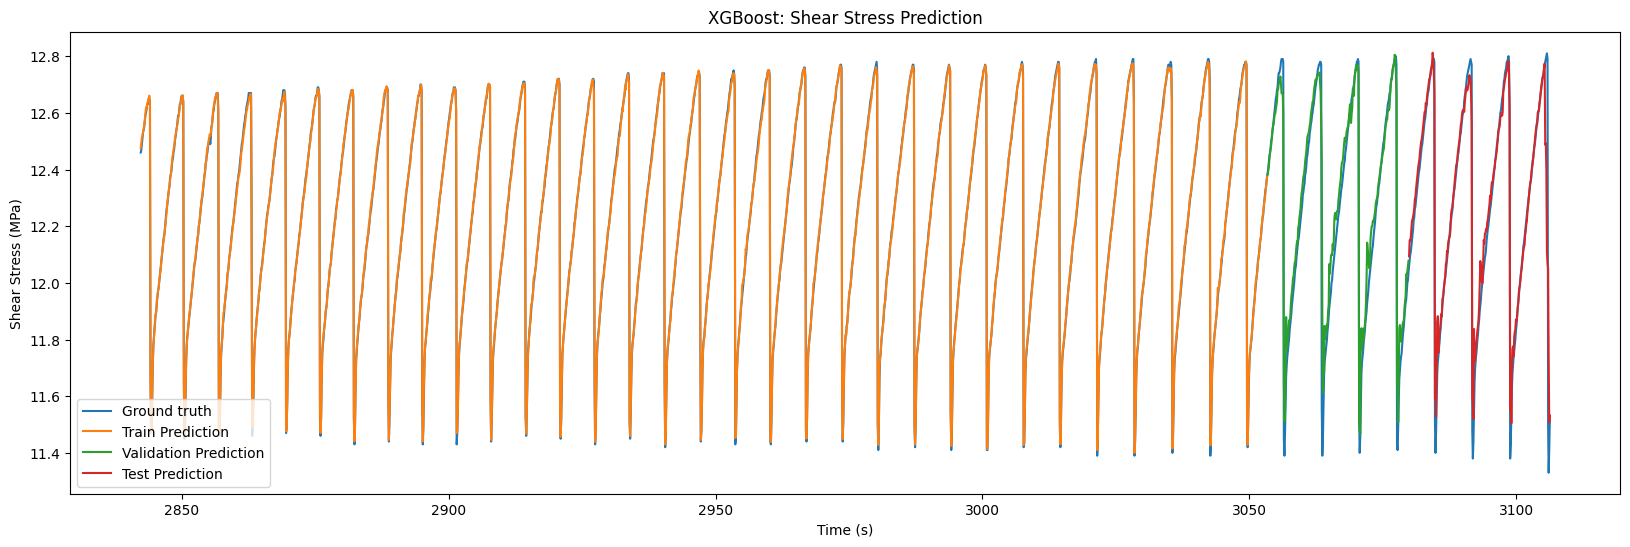

In [12]:
# Overall plot: SS
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predTrain.iloc[:,0])
plt.plot(valtime, y_predVal.iloc[:,0])
plt.plot(testtime, y_predTest.iloc[:,0])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Shear Stress Prediction')

In [13]:
# # Parameter tuning

# params = {
#         'learning_rate': [0.01, 0.1, 0.5],
#         'n_estimators': [200, 600, 1000],
#         'max_depth': [3, 6, 9],
#         'objective':['reg:squarederror']
#         }

# best_score = 0

# for g in ParameterGrid(params):
#   model = XGBRegressor()
#   model.set_params(**g)
#   model.fit(X_train, Y_train_TTF)
#   y_predVal = model.predict(X_val)
#   val_r2 = r2_score(Y_val_TTF, y_predVal)
#   if val_r2 > best_score:
#     best_score = val_r2
#     best_grid = g
# #print(best_grid)

In [14]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
start_time = time.time()
model.fit(X_train, Y_train_TTF, eval_set=[(X_val, Y_val_TTF)],early_stopping_rounds=20)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

[0]	validation_0-rmse:2.08891


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:2.07259
[2]	validation_0-rmse:2.05647
[3]	validation_0-rmse:2.04060
[4]	validation_0-rmse:2.02492
[5]	validation_0-rmse:2.00946
[6]	validation_0-rmse:1.99445
[7]	validation_0-rmse:1.97946
[8]	validation_0-rmse:1.96455
[9]	validation_0-rmse:1.95043
[10]	validation_0-rmse:1.93603
[11]	validation_0-rmse:1.92210
[12]	validation_0-rmse:1.90758
[13]	validation_0-rmse:1.89307
[14]	validation_0-rmse:1.87888
[15]	validation_0-rmse:1.86487
[16]	validation_0-rmse:1.85201
[17]	validation_0-rmse:1.83836
[18]	validation_0-rmse:1.82486
[19]	validation_0-rmse:1.81158
[20]	validation_0-rmse:1.79884
[21]	validation_0-rmse:1.78658
[22]	validation_0-rmse:1.77471
[23]	validation_0-rmse:1.76232
[24]	validation_0-rmse:1.74978
[25]	validation_0-rmse:1.73808
[26]	validation_0-rmse:1.72589
[27]	validation_0-rmse:1.71418
[28]	validation_0-rmse:1.70217
[29]	validation_0-rmse:1.69099
[30]	validation_0-rmse:1.68028
[31]	validation_0-rmse:1.66914
[32]	validation_0-rmse:1.65744
[33]	validation_0

In [15]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))

ttf_train_r2 = r2_score(Y_train_TTF, y_predTrain)
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train_TTF, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))

ttf_val_r2 = r2_score(Y_val_TTF, y_predVal)
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val_TTF, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ttf_test_r2 = r2_score(y_test_TTF, y_predTest)
ttf_test_rmse = np.sqrt(mean_squared_error(y_test_TTF, y_predTest))

## Print
print('\nTTF')
print('R2 score:', ttf_train_r2, ttf_val_r2, ttf_test_r2, '\nRMSE:', ttf_train_rmse, ttf_val_rmse , ttf_test_rmse)


TTF
R2 score: 0.9982780202090002 0.9033880226112623 0.7294963136783224 
RMSE: 0.07934506555761275 0.6507170880656011 1.0354132878477413


Text(0.5, 1.0, 'XGBoost: TTF Prediction')

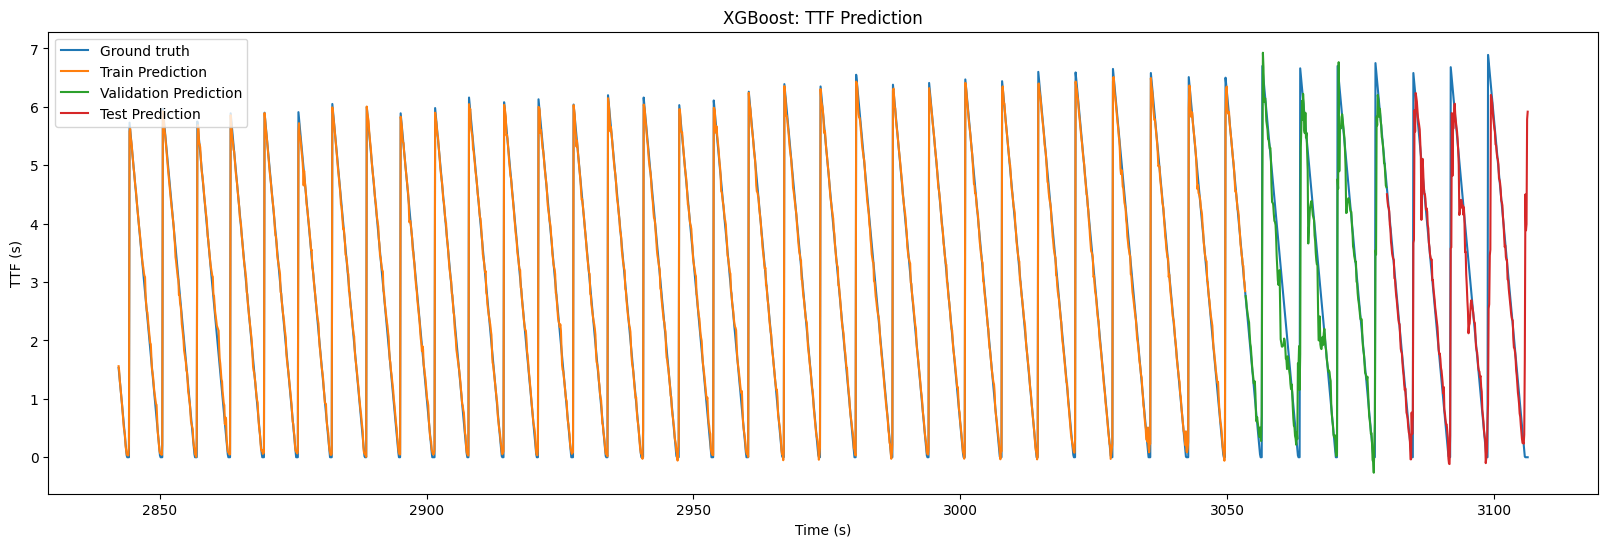

In [16]:
# Overall plot: TTF
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

## TTF
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predTrain.iloc[:,0])
plt.plot(valtime, y_predVal.iloc[:,0])
plt.plot(testtime, y_predTest.iloc[:,0])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: TTF Prediction')

In [17]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5759/Data')
Data1 = loadmat('p5759_Inputs.mat')
Data2 = loadmat('p5759_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['AE','ln_V_V0']]
xdf = df[['AE']]
ydf = df[['ln_V_V0']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
          AE
0      1.50
1      1.67
2      1.67
3      1.33
4      1.33
...     ...
2549  21.00
2550  28.00
2551  26.67
2552   8.67
2553   2.00

[2554 rows x 1 columns]
Target Data:
       ln_V_V0
0      -11.51
1      -11.51
2      -11.51
3      -11.51
4      -11.51
...       ...
2549   -11.51
2550     1.45
2551   -11.51
2552   -11.51
2553   -11.51

[2554 rows x 1 columns]


In [18]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1:]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [19]:
# Preprocessing
arr = df.to_numpy()
n_steps = 100
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (2454, 100, 1)
Target shape, Y =  (2454, 1)
After reshaping, X =  (2454, 100)


In [20]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state = 0, test_size=0.111, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples:", np.shape(Y_train))
print("Validation output samples:", np.shape(Y_val))
print("Testing output samples:", np.shape(y_test))

Training input samples: (1962, 100)
Validation input samples: (246, 100)
Testing input samples: (246, 100)
Training output samples: (1962, 1)
Validation output samples: (246, 1)
Testing output samples: (246, 1)


In [21]:
# # Parameter tuning

# params = {
#         'learning_rate': [0.01, 0.1, 0.5],
#         'n_estimators': [200, 600, 1000],
#         'max_depth': [3, 6, 9],
#         'objective':['reg:squarederror']
#         }

# best_score = 0

# for g in ParameterGrid(params):
#   model = XGBRegressor()
#   model.set_params(**g)
#   model.fit(X_train, Y_train_SR)
#   y_predVal = model.predict(X_val)
#   val_r2 = r2_score(Y_val_SR, y_predVal)
#   if val_r2 > best_score:
#     best_score = val_r2
#     best_grid = g
# #print(best_grid)

In [22]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
start_time = time.time()
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)],early_stopping_rounds=20)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

[0]	validation_0-rmse:1.76625
[1]	validation_0-rmse:1.75547
[2]	validation_0-rmse:1.74483
[3]	validation_0-rmse:1.73433
[4]	validation_0-rmse:1.72398
[5]	validation_0-rmse:1.71377
[6]	validation_0-rmse:1.70369
[7]	validation_0-rmse:1.69376
[8]	validation_0-rmse:1.68395
[9]	validation_0-rmse:1.67429
[10]	validation_0-rmse:1.66475
[11]	validation_0-rmse:1.65535
[12]	validation_0-rmse:1.64607
[13]	validation_0-rmse:1.63693
[14]	validation_0-rmse:1.62791
[15]	validation_0-rmse:1.61902
[16]	validation_0-rmse:1.61025
[17]	validation_0-rmse:1.60161
[18]	validation_0-rmse:1.59309
[19]	validation_0-rmse:1.58469
[20]	validation_0-rmse:1.57640
[21]	validation_0-rmse:1.56824
[22]	validation_0-rmse:1.56019
[23]	validation_0-rmse:1.55226


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:1.54445
[25]	validation_0-rmse:1.53674
[26]	validation_0-rmse:1.52915
[27]	validation_0-rmse:1.52167
[28]	validation_0-rmse:1.51430
[29]	validation_0-rmse:1.50703
[30]	validation_0-rmse:1.49987
[31]	validation_0-rmse:1.49282
[32]	validation_0-rmse:1.48587
[33]	validation_0-rmse:1.47903
[34]	validation_0-rmse:1.47228
[35]	validation_0-rmse:1.46564
[36]	validation_0-rmse:1.45910
[37]	validation_0-rmse:1.45266
[38]	validation_0-rmse:1.44631
[39]	validation_0-rmse:1.44006
[40]	validation_0-rmse:1.43390
[41]	validation_0-rmse:1.42784
[42]	validation_0-rmse:1.42187
[43]	validation_0-rmse:1.41599
[44]	validation_0-rmse:1.41020
[45]	validation_0-rmse:1.40450
[46]	validation_0-rmse:1.39889
[47]	validation_0-rmse:1.39336
[48]	validation_0-rmse:1.38793
[49]	validation_0-rmse:1.38257
[50]	validation_0-rmse:1.37730
[51]	validation_0-rmse:1.37211
[52]	validation_0-rmse:1.36701
[53]	validation_0-rmse:1.36198
[54]	validation_0-rmse:1.35704
[55]	validation_0-rmse:1.35217
[56]	val

In [23]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))
sr_train_r2 = r2_score(Y_train, y_predTrain)
sr_train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))
sr_val_r2 = r2_score(Y_val, y_predVal)
sr_val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))
sr_test_r2 = r2_score(y_test, y_predTest)
sr_test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

## Print
print('\nSlip rate')
print('R2 score:', sr_train_r2, sr_val_r2, sr_test_r2, '\nRMSE:', sr_train_rmse, sr_val_rmse , sr_test_rmse)


Slip rate
R2 score: 0.9997046981336385 0.6847445386100023 0.5301044910888677 
RMSE: 0.02886232268774502 0.9976746365661823 1.1272786470280383


Text(0.5, 1.0, 'XGBoost: Slip Rate Prediction')

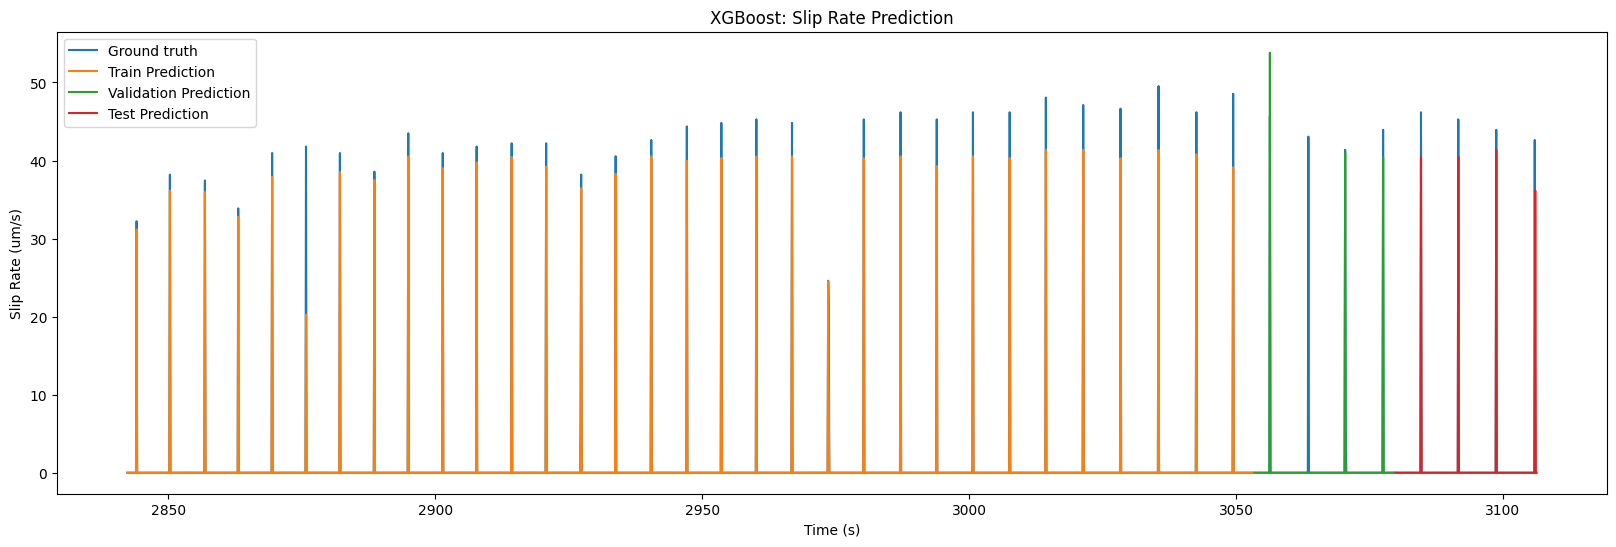

In [24]:
# Overall plot: Slip Rate
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

# Scale
ydf_scale = ydf
ydf_scale = np.exp(ydf_scale)*10;

y_predTrain_scale = y_predTrain
y_predTrain_scale = np.exp(y_predTrain_scale)*10;

y_predVal_scale = y_predVal
y_predVal_scale = np.exp(y_predVal_scale)*10;

y_predTest_scale = y_predTest
y_predTest_scale = np.exp(y_predTest_scale)*10;

## SR
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_scale)
plt.plot(traintime, y_predTrain_scale)
plt.plot(valtime, y_predVal_scale)
plt.plot(testtime, y_predTest_scale)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Slip Rate Prediction')